In [1]:
import matplotlib.pyplot as plt
from zipfile import ZipFile

def unzip(nm):
    with ZipFile("archive.zip","r") as zip:
        zip.extractall()

unzip("archive.zip")

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    directory = "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "training",
    seed = 1234,
    shuffle = True,
    image_size = (224,224),
    batch_size = 32,
)

val_ds = image_dataset_from_directory(
    directory = "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "validation",
    seed = 1234,
    shuffle = True,
    image_size = (224,224),
    batch_size = 32,
)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


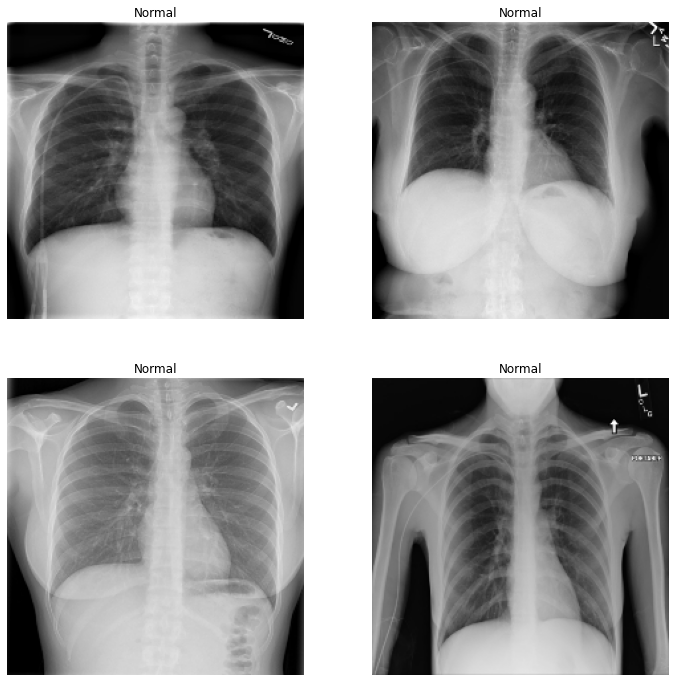

In [3]:
from tensorflow.data.experimental import cardinality

val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.take(val_batches//5)

class_names = train_ds.class_names

plt.figure(figsize=(12,12))
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [4]:
from tensorflow.data import AUTOTUNE

Autotune = AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=Autotune)
val_ds = val_ds.prefetch(buffer_size=Autotune)
test_ds = test_ds.prefetch(buffer_size=Autotune)

In [5]:
from tensorflow.keras.layers import RandomZoom, RandomRotation
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    RandomZoom(0.2),
    RandomRotation(0.1),
])


from tensorflow.keras.applications import densenet, DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy

rescale = densenet.preprocess_input

base_model = DenseNet201(input_shape=(224,224,3),include_top=False,weights="imagenet")
base_model.trainable = False

def model(input):
    x = data_augmentation(input)
    x = rescale(x)
    x = base_model(x,training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2,seed=1234)(x)
    output = Dense(2,activation="softmax")(x)
    model = Model(input,output,name="Transfer_DenseNet201")
    return model

model = model(Input(shape=(224,224,3)))
model.summary()
model.compile(RMSprop(),SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "Transfer_DenseNet201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)     

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

if __name__=="__main__":
    checkpoint = [
        ModelCheckpoint("tuberculosis.h5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    ]
    model.fit(train_ds,epochs=7,validation_data=val_ds,callbacks=checkpoint)
    best = load_model("tuberculosis.h5")
    val_loss,val_accuracy = best.evaluate(val_ds)
    test_loss,test_accuracy = best.evaluate(test_ds)
    print("\nVal accuracy: {:.2f} %".format(100*val_accuracy))
    print("Val loss: {:.2f} %".format(100*val_loss))
    print("\nTest accuracy: {:.2f} %".format(100*test_accuracy))
    print("Test loss: {:.2f} %".format(100*test_loss))

Epoch 1/7
105/105 [==============================] - 42s 292ms/step - loss: 0.2817 - accuracy: 0.8976 - val_loss: 0.2056 - val_accuracy: 0.9312
Epoch 2/7
105/105 [==============================] - 29s 272ms/step - loss: 0.1536 - accuracy: 0.9467 - val_loss: 0.1242 - val_accuracy: 0.9375
Epoch 3/7
105/105 [==============================] - 29s 273ms/step - loss: 0.1253 - accuracy: 0.9536 - val_loss: 0.1128 - val_accuracy: 0.9688
Epoch 4/7
105/105 [==============================] - 29s 272ms/step - loss: 0.1114 - accuracy: 0.9589 - val_loss: 0.1114 - val_accuracy: 0.9750
Epoch 5/7
105/105 [==============================] - 28s 266ms/step - loss: 0.0983 - accuracy: 0.9595 - val_loss: 0.0810 - val_accuracy: 0.9812
Epoch 6/7
105/105 [==============================] - 28s 266ms/step - loss: 0.0962 - accuracy: 0.9622 - val_loss: 0.1202 - val_accuracy: 0.9563
Epoch 7/7
5/5 [==============================] - 2s 240ms/step - loss: 0.0721 - accuracy: 0.9750

Val accuracy: 98.12 %
Val loss: 5.20 %